<a href="https://colab.research.google.com/github/JuanAzevedo/dataset_heart_disease_prediction/blob/main/ML_Predicao_Doencas_Cardiacas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importando as Bibliotecas


In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Carga do Dataset

In [ ]:
url = "https://raw.githubusercontent.com/JuanAzevedo/dataset_heart_disease_prediction/refs/heads/main/Heart_Disease_Prediction.csv"

dataset = pd.read_csv(url, delimiter=',')

dataset.head()

,Age,Sex,Chest pain type,BP,Cholesterol,FBS over 120,EKG results,Max HR,Exercise angina,ST depression,Slope of ST,Number of vessels fluro,Thallium,Heart Disease
0,70,1,4,130,322,0,2,109,0,2.4,2,3,3,Presence
1,67,0,3,115,564,0,2,160,0,1.6,2,0,7,Absence
2,57,1,2,124,261,0,0,141,0,0.3,1,0,7,Presence
3,64,1,4,128,263,0,0,105,1,0.2,2,1,7,Absence
4,74,0,2,120,269,0,2,121,1,0.2,1,1,3,Absence


## Separação em conjunto de treino e conjunto de teste com holdout

In [ ]:
test_size = 0.20
seed = 7

# Separação em conjuntos de treino e teste
array = dataset.values
X = dataset[['Age', 'Sex', 'BP', 'Cholesterol', 'Chest pain type', 'ST depression']].values

# 'y' continua sendo a coluna de diagnóstico ou alvo
y = dataset['Heart Disease'].values
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.592857 (0.072841)
CART: 0.602597 (0.099181)
NB: 0.750433 (0.083820)
SVM: 0.546537 (0.029460)


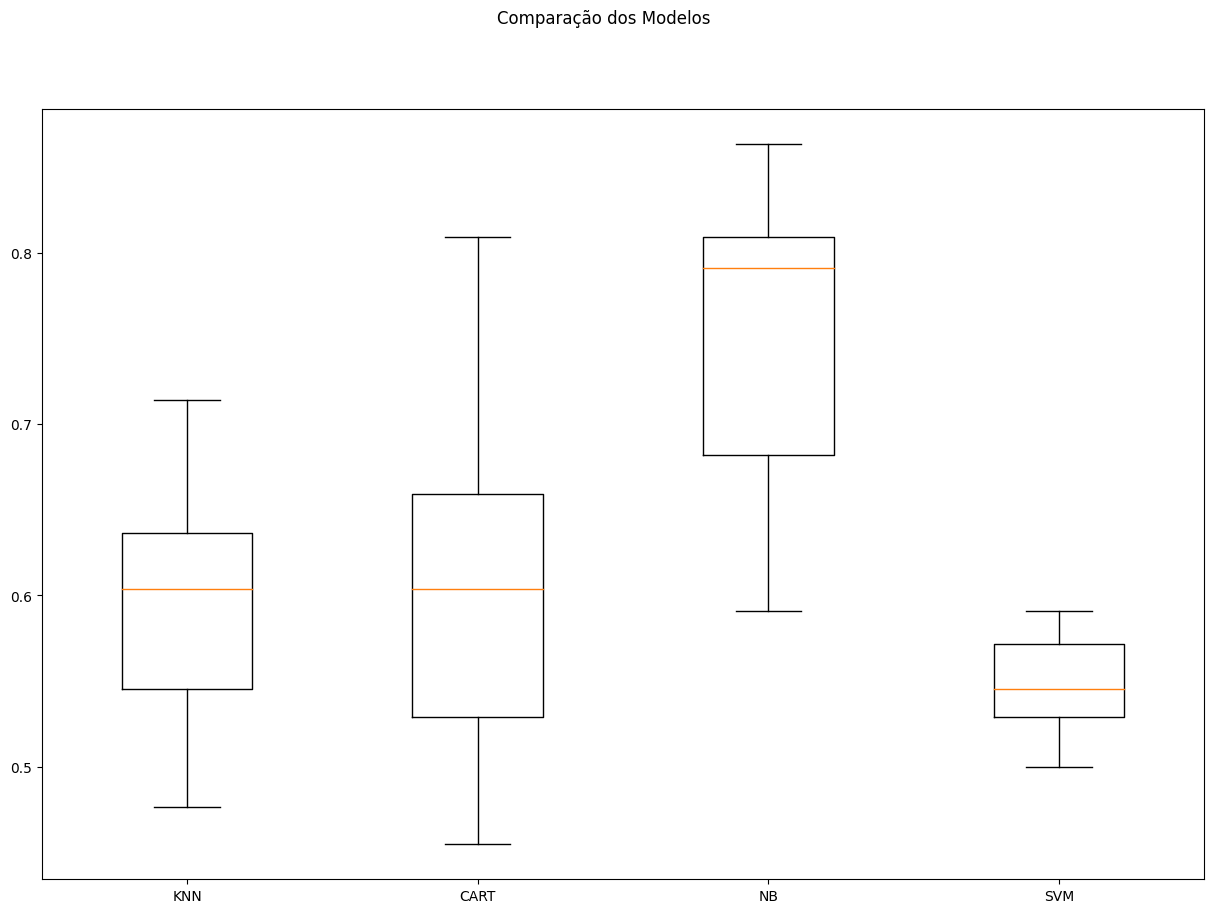

In [ ]:
np.random.seed(7)

models = []

models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.593 (0.073)
CART-orig: 0.603 (0.099)
NB-orig: 0.750 (0.084)
SVM-orig: 0.547 (0.029)
KNN-padr: 0.775 (0.113)
CART-padr: 0.608 (0.112)
NB-padr: 0.750 (0.084)
SVM-padr: 0.761 (0.110)
KNN-norm: 0.779 (0.105)
CART-norm: 0.602 (0.099)
NB-norm: 0.750 (0.084)
SVM-norm: 0.755 (0.106)


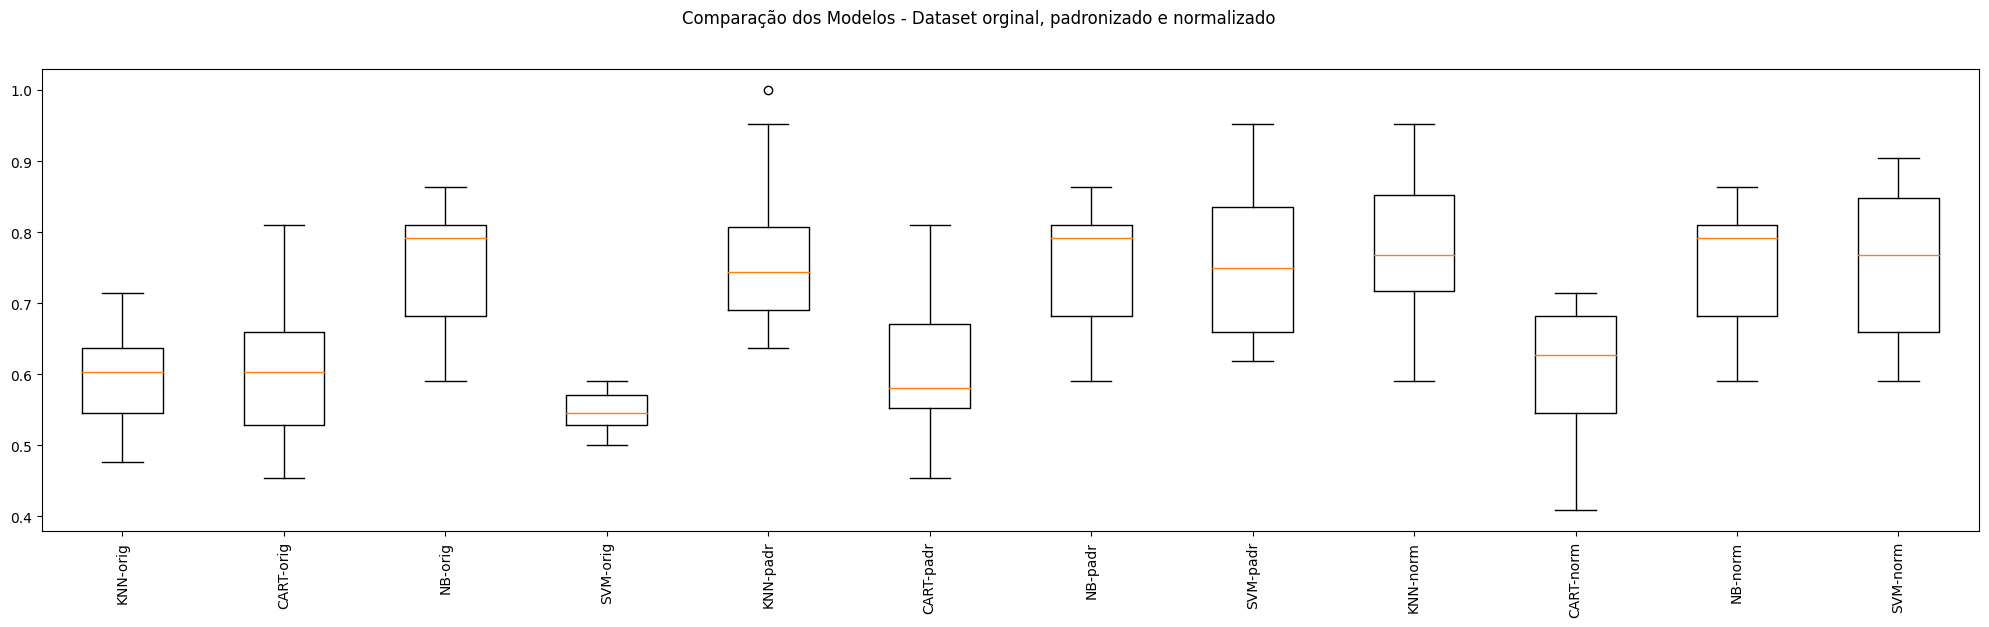

In [ ]:
np.random.seed(7)

pipelines = []
results = []
names = []


# Criando os elementos do pipeline

knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [ ]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Sem tratamento de missings: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Sem tratamento de missings: knn-orig - Melhor: 0.653680 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 19}
Sem tratamento de missings: knn-padr - Melhor: 0.792424 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 7}
Sem tratamento de missings: knn-norm - Melhor: 0.792424 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 7}


## Finalização do Modelo

In [ ]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='manhattan', n_neighbors=7)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))

0.7962962962962963


In [ ]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='manhattan', n_neighbors=7)

## Simulando a aplicação do modelo em dados não vistos

In [ ]:
# Novos dados - não sabemos a classe!
data = {'Age' : [22, 32, 59],
        'Sex' : [0, 1, 1],
        'BP' : [100, 140, 80],
        'Cholesterol' : [350, 289, 333],
        'Chest pain type' :[3, 4, 2],
        'ST depression' : [0.9, 1.2, 3.2],
}
atributos = ['Age', 'Sex', 'BP', 'Cholesterol', 'Chest pain type', 'ST depression']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:6].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[-3.5671671  -1.45032695 -1.75810884  1.9449486  -0.18355874 -0.13122359]
 [-2.46732113  0.6894997   0.48548982  0.76255884  0.87092765  0.13122359]
 [ 0.50226299  0.6894997  -2.87990817  1.61543014 -1.23804513  1.88087152]]


In [ ]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

['Absence' 'Presence' 'Presence']


## Contexto do Problema
Neste projeto, o objetivo é criar um modelo de machine learning para prever a presença de doenças cardíacas usando dados clínicos de pacientes. O dataset inclui várias características, como idade, sexo, pressão arterial, colesterol, tipo de dor no peito, entre outras. O problema é de classificação, já que o modelo deve aprender a diferenciar entre pacientes com e sem doença cardíaca com base nessas informações.


# Escolha do Modelo e Pré-processamento

Após explorar o dataset e preparar os dados, decidi testar alguns algoritmos de machine learning, como K-Nearest Neighbors (KNN), Árvore de Decisão (CART), Naive Bayes (NB) e Máquina de Vetores de Suporte (SVM).

Durante os testes, o algoritmo KNN se destacou com resultados promissores. No entanto, como o KNN é sensível à escala das variáveis, resolvi aplicar técnicas de pré-processamento, como padronização e normalização dos dados, para garantir que todas as variáveis contribuam de maneira equilibrada no cálculo das distâncias.

# Otimização dos Parâmetros do KNN

O K-Nearest Neighbors (KNN) classifica os dados com base nas amostras mais próximas. Como ele depende muito da distância entre os dados, percebi que seria importante ajustar dois parâmetros principais:

n_neighbors: O número de vizinhos considerados para a classificação.
métrica de distância (metric): A métrica usada para calcular a distância entre os pontos (Euclidiana, Manhattan ou Minkowski).
Para encontrar os melhores valores, usei GridSearchCV, que testou várias combinações de parâmetros e identificou as melhores.

# Resultados e Justificativa para a Escolha

Testei o KNN com e sem pré-processamento, e os resultados foram bem claros:

O KNN sem nenhum pré-processamento teve um desempenho bem abaixo do esperado, com acurácia em torno de 65%.
Com a padronização e a normalização, o modelo apresentou uma melhora significativa, atingindo uma acurácia de cerca de 79%. A melhor configuração foi usar a métrica Manhattan e 7 vizinhos.
Com base nesses resultados, decidi seguir com o KNN padronizado. A padronização mostrou-se eficiente em garantir que todas as variáveis tivessem o mesmo peso no cálculo das distâncias, sem impactar tanto quanto a normalização.

A escolha final pelo KNN com padronização e métrica Manhattan foi guiada por:

Desempenho: A acurácia de 79% foi consistente durante os testes, e a variação foi baixa, o que mostra que o modelo está funcionando bem e sem sinais de overfitting.
Simplicidade: O KNN é um algoritmo fácil de entender e implementar, e faz bastante sentido para problemas onde a proximidade entre os dados é importante. Além disso, com a padronização, as diferentes escalas das variáveis não interferem tanto no resultado.